In [1]:
import numpy as np 
import pandas as pd 
import math
import seaborn as sns
import datetime as dt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime    
sns.set_style("whitegrid")
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau



In [2]:
# Set random seeds for reproducibility
torch.set_num_threads(4) 

data = pd.read_csv('./meta.csv')
data.head()

# Reset index
data.reset_index(drop=True, inplace=True)

# Select numeric columns
numeric_data = data.select_dtypes(include=[np.number])

# Fill NaN values in numeric columns with the mean of those columns
data[numeric_data.columns] = data[numeric_data.columns].fillna(numeric_data.mean())

# Display the first few rows of the DataFrame
print(data.head())

# Calculate moving average
ma_day = [5, 10, 20, 50]  # Common short-term and long-term windows
for ma in ma_day:
    column_name = f"MA for {ma} days"
    data[column_name] = data['Close'].rolling(window=ma).mean()

# Calculate Exponential moving average
for ma in ma_day:
    column_name = f"EMA for {ma} days"
    data[column_name] = data['Close'].ewm(span=ma, adjust=False).mean()


def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data['Close'])  


data.dropna(inplace=True)
data.head(500)

         Date   Open   High    Low    Close     Volume
0  2012-05-18  42.05  45.00  38.00  38.2318  573576400
1  2012-05-21  36.53  36.66  33.00  34.0300  168192700
2  2012-05-22  32.61  33.59  30.94  31.0000  101786600
3  2012-05-23  31.37  32.50  31.36  32.0000   73600000
4  2012-05-24  32.95  33.21  31.77  33.0300   50237200


,Date,Open,High,Low,Close,Volume,MA for 5 days,MA for 10 days,MA for 20 days,MA for 50 days,EMA for 5 days,EMA for 10 days,EMA for 20 days,EMA for 50 days,RSI_14
49,2012-07-30,23.995,24.04,23.030,23.15,29285900,26.29800,27.52000,29.237800,29.838636,25.546291,27.046144,28.449746,30.538853,15.733114
50,2012-07-31,23.370,23.37,21.610,21.71,56179400,24.95000,26.88200,28.784750,29.508200,24.267527,26.075936,27.807865,30.192623,14.602446
51,2012-08-01,21.500,21.58,20.840,20.88,44604400,23.25800,26.05900,28.268750,29.245200,23.138351,25.131220,27.148068,29.827422,13.890909
52,2012-08-02,20.770,20.84,19.820,20.04,56374500,21.89700,25.16300,27.697250,29.026000,22.105568,24.205544,26.471110,29.443602,13.172414
53,2012-08-03,20.360,22.16,19.900,21.09,80647000,21.37400,24.39600,27.165250,28.807800,21.767045,23.639081,25.958623,29.116010,22.638623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
544,2014-07-21,68.810,69.96,68.500,69.40,49431600,67.81096,66.58973,66.626865,64.001716,68.007206,67.283914,66.478537,64.769416,56.251778
545,2014-07-22,69.760,69.77,68.610,69.27,40301800,68.23196,67.24073,66.821865,64.242316,68.428138,67.645020,66.744391,64.945909,53.726471
546,2014-07-23,69.740,71.33,69.610,71.29,77435900,68.95796,67.87273,67.100365,64.471516,69.382092,68.307744,67.177306,65.194697,64.538726
547,2014-07-24,75.960,76.74,74.510,74.98,124006900,70.67198,68.88348,67.477365,64.774516,71.248061,69.520881,67.920420,65.578435,71.536342


In [3]:
# Select key features
# selected_features = ['Close', 'Volume', 'EMA for 50 days', 'MACD', 'RSI_14']

selected_features = [
    'Close',          # Most important feature (direct price information)
    'Low',            # Important price-related feature
    'High',           # Important price-related feature
    'Open',           # Important price-related feature
    'EMA for 5 days', # Short-term trend indicator
    'MA for 5 days',  # Short-term trend indicator
    'RSI_14'          # Momentum indicator
]

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[selected_features])

# Create sequences with reduced length
sequence_length = 30  # Reduced from 60
X = []
y = []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:(i + sequence_length)])
    y.append(scaled_data[i + sequence_length, 0])

X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Split into train and validation sets
train_size = int(0.8 * len(X))
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Create DataLoader with larger batch size
batch_size = 128  # Increased batch size
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)


class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        pe = pe.transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class FastStockPredictor(nn.Module):
    def __init__(self, input_dim, d_model=128, nhead=4, num_encoder_layers=2, hidden_dim=64):
        super().__init__()
        
        # Input processing
        self.input_projection = nn.Linear(input_dim, d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=0.1,
            batch_first=True,
            activation=F.gelu
        )
        
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_encoder_layers
        )
        
        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=d_model,
            hidden_size=hidden_dim,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        # Output processing
        self.layer_norm2 = nn.LayerNorm(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, 1)
        
    def forward(self, x):
        # Input processing
        x = self.input_projection(x)
        x = self.layer_norm1(x)
        
        # Transformer encoding
        x = self.transformer_encoder(x)
        
        # LSTM processing
        lstm_out, _ = self.lstm(x)
        
        # Take the last timestep
        x = lstm_out[:, -1, :]
        x = self.layer_norm2(x)
        
        # Final prediction
        return self.fc(x)
    
# Initialize the model


In [4]:
from torch.optim.lr_scheduler import StepLR


def train_model_fast(model, train_loader, val_loader, num_epochs=30):
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
    # Change the scheduler to StepLR
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0
    training_losses = []
    validation_losses = []
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_train_loss = 0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            total_train_loss += loss.item()
        
        # Step the scheduler at the end of each epoch
        scheduler.step()
        
        avg_train_loss = total_train_loss / len(train_loader)
        training_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        total_val_loss = 0
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs.squeeze(), batch_y)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        validation_losses.append(avg_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {avg_train_loss:.6f} - '
              f'Val Loss: {avg_val_loss:.6f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            print("Early stopping triggered")
            break
    
    return training_losses, validation_losses

# 3. Initialize model and train
input_dim = len(selected_features)
model = FastStockPredictor(input_dim=input_dim)

# 4. Create data loaders
batch_size = 256
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# 5. Train the model
training_losses, validation_losses = train_model_fast(model, train_loader, val_loader)

# Train the model
# training_losses, validation_losses = train_model(model, train_loader, val_loader)



Epoch [1/30] - Train Loss: 0.832509 - Val Loss: 0.059065
Epoch [2/30] - Train Loss: 0.019398 - Val Loss: 0.053827
Epoch [3/30] - Train Loss: 0.012342 - Val Loss: 0.022440
Epoch [4/30] - Train Loss: 0.003909 - Val Loss: 0.006084
Epoch [5/30] - Train Loss: 0.001853 - Val Loss: 0.003377
Epoch [6/30] - Train Loss: 0.000879 - Val Loss: 0.002871
Epoch [7/30] - Train Loss: 0.000733 - Val Loss: 0.002017
Epoch [8/30] - Train Loss: 0.000713 - Val Loss: 0.001968
Epoch [9/30] - Train Loss: 0.000631 - Val Loss: 0.001587
Epoch [10/30] - Train Loss: 0.000569 - Val Loss: 0.002259
Epoch [11/30] - Train Loss: 0.000631 - Val Loss: 0.001403
Epoch [12/30] - Train Loss: 0.000552 - Val Loss: 0.001367
Epoch [13/30] - Train Loss: 0.000492 - Val Loss: 0.001301
Epoch [14/30] - Train Loss: 0.000501 - Val Loss: 0.001332
Epoch [15/30] - Train Loss: 0.000443 - Val Loss: 0.001197
Epoch [16/30] - Train Loss: 0.000469 - Val Loss: 0.001307
Epoch [17/30] - Train Loss: 0.000471 - Val Loss: 0.001388
Epoch [18/30] - Train L

In [5]:
# Make predictions
predictions = []
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_X, _ in val_loader:
        outputs = model(batch_X)
        predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

# Get actual values
actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]




Final Model Performance Metrics:
MSE: 190.373
RMSE: 13.798
MAE: 10.203
R2 Score: 0.973


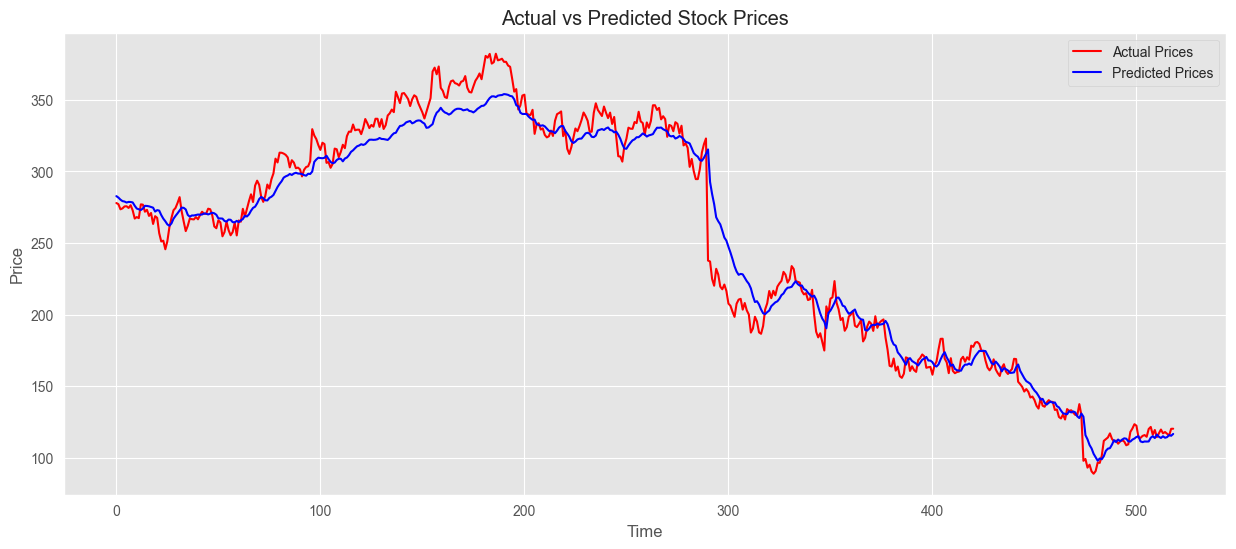

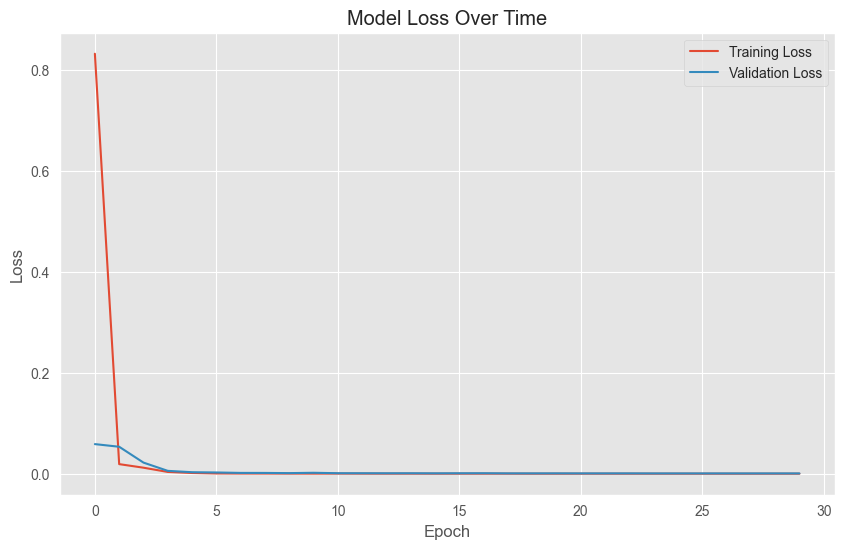

In [6]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# Calculate metrics
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nFinal Model Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(10, 6))
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Model Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# criterion = nn.MSELoss()  # Changed to simpler loss function
# optimizer = torch.optim.Adam([
#     {'params': input_projection.parameters()},
#     {'params': transformer_encoder.parameters()},
#     {'params': lstm.parameters()},
#     {'params': fc1.parameters()},
#     {'params': fc2.parameters()}
# ], lr=0.001)

# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=5,
#     verbose=True
# )

# Training loop
# num_epochs = 50  # Reduced epochs
# best_val_loss = float('inf')
# patience = 7   # Reduced patience
# patience_counter = 0
# training_losses = []
# validation_losses = []

# for epoch in range(num_epochs):
    # Training phase
    total_train_loss = 0
    
    for batch_X, batch_y in train_loader:
        
        # Forward pass
        x = input_projection(batch_X)
        x = layer_norm(x)
        x = transformer_encoder(x)
        lstm_out, _ = lstm(x)
        x = fc1(lstm_out[:, -1, :])
        x = F.gelu(x)
        outputs = fc2(x)
        
        # Calculate loss
        loss = criterion(outputs.squeeze(), batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    training_losses.append(avg_train_loss)
    
    # Validation phase
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            # Validation step (no device moving needed)
            
            x = input_projection(batch_X)
            x = layer_norm(x)
            x = transformer_encoder(x)
            lstm_out, _ = lstm(x)
            x = fc1(lstm_out[:, -1, :])
            x = F.gelu(x)
            outputs = fc2(x)
            
            loss = criterion(outputs.squeeze(), batch_y)
            total_val_loss += loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    validation_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Print progress with batch count
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
          f'Batches: {len(train_loader)} - '
          f'Train Loss: {avg_train_loss:.6f} - '
          f'Val Loss: {avg_val_loss:.6f}')
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save({
            'input_projection': input_projection.state_dict(),
            'transformer_encoder': transformer_encoder.state_dict(),
            'lstm': lstm.state_dict(),
            'fc1': fc1.state_dict(),
            'fc2': fc2.state_dict()
        }, 'best_model.pth')
        patience_counter = 0
    else:
        patience_counter += 1
        
    if patience_counter >= patience:
        print("Early stopping triggered")
        break

input_dim = len(selected_features)
model = FastStockPredictor(input_dim=input_dim)

# Create data loaders with larger batch size
batch_size = 256
train_data = torch.utils.data.TensorDataset(X_train, y_train)
val_data = torch.utils.data.TensorDataset(X_val, y_val)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size)

# Train the model
training_losses, validation_losses = train_model_fast(model, train_loader, val_loader)


NameError: name 'input_projection' is not defined

In [7]:
predictions = []
model.eval()  # Add this line
with torch.no_grad():
    for batch_X, _ in val_loader:
        
        outputs = model(batch_X)  # Updated to use new model
        predictions.extend(outputs.cpu().numpy())

In [9]:
# Make predictions
# predictions = []
# with torch.no_grad():
#     for batch_X, _ in val_loader:
#         batch_X = batch_X.to(device)
#         x = input_projection(batch_X)
#         x = layer_norm(x)
#         x = transformer_encoder(x)
#         lstm_out, _ = lstm(x)
#         x = fc1(lstm_out[:, -1, :])
#         x = F.gelu(x)
#         outputs = fc2(x)
#         predictions.extend(outputs.cpu().numpy())

# Convert predictions back to original scale
predictions = np.array(predictions).reshape(-1, 1)
zeros_array = np.zeros((predictions.shape[0], len(selected_features)-1))
predictions_full = np.concatenate([predictions, zeros_array], axis=1)
predictions = scaler.inverse_transform(predictions_full)[:, 0]

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required.


Final Model Performance Metrics:
MSE: 590.562
RMSE: 24.301
MAE: 19.403
R2 Score: 0.915


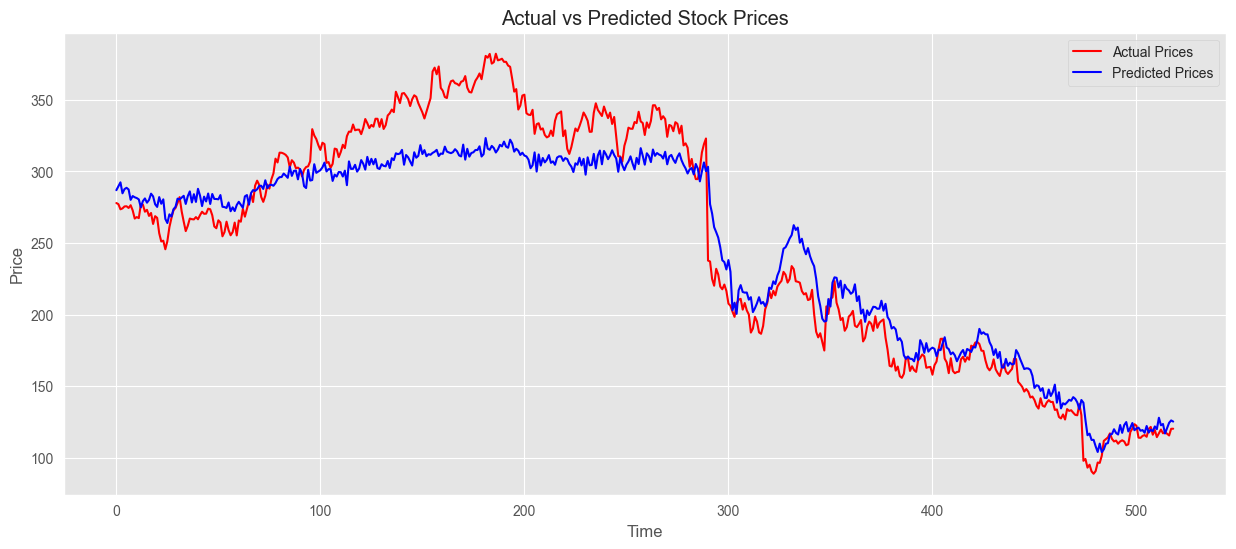

In [94]:
# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

actual_prices = scaler.inverse_transform(scaled_data[train_size+sequence_length:])[:, 0]
mse = mean_squared_error(actual_prices, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_prices, predictions)
r2 = r2_score(actual_prices, predictions)

print("\nFinal Model Performance Metrics:")
print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R2 Score: {r2:.3f}")

# Plot results
plt.figure(figsize=(15, 6))
plt.plot(actual_prices, label='Actual Prices', color='red')
plt.plot(predictions, label='Predicted Prices', color='blue')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

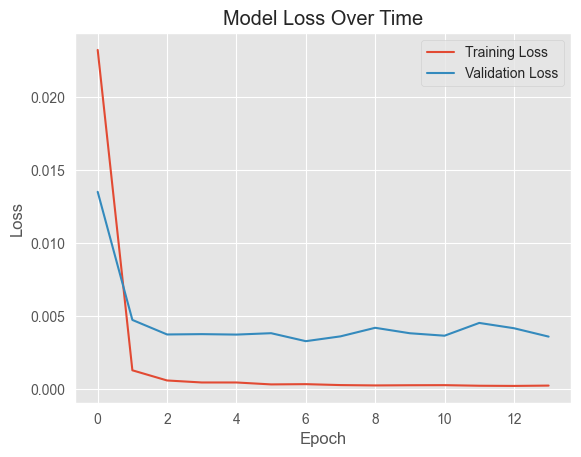

In [95]:
def plot_loss(training_losses, validation_losses):
    plt.plot(training_losses, label='Training Loss')
    plt.plot(validation_losses, label='Validation Loss')
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(training_losses, validation_losses)